In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [149]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min_mean = add!(model, datavar(:xt_min_mean, Float64))
    xt_min_var  = add!(model, datavar(:xt_min_var, Float64))
    xt_min      = add!(model, randomvar(:xt_min))
    
    xt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, xt_min_mean, xt_min_var, xt_min))
    
    zt_min_mean = add!(model, datavar(:zt_min_mean, Float64))
    zt_min_var  = add!(model, datavar(:zt_min_var, Float64))
    zt_min      = add!(model, randomvar(:zt_min))
    
    zt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, zt_min_mean, zt_min_var, zt_min))
    
    zvar   = add!(model, constvar(:zvar, 1.0))
    zt     = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(NormalMeanVariance{Float64}, zt_min, zvar, zt, factorisation = ((1,),(2,),(3,))))
    
    xt = add!(model, randomvar(:xt))
    kt = add!(model, constvar(:kt, 0.1))
    ωt = add!(model, constvar(:wt, 0.0))
    
    gcv = add!(model, make_node(GCV, xt_min, zt, kt, ωt, xt))
    
    y_var = add!(model, constvar(:y_var, 1.0))
    y     = add!(model, datavar(:y, Float64))
    
    obs = add!(model, make_node(NormalMeanVariance{Float64}, xt, y_var, y))
    
    activate!(model)
    
    # Prior marginals
    setmarginal!(gcv, :x_y, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    
    mz = Vector{NormalMeanVariance}()
    mx = Vector{NormalMeanVariance}()

    s_mz = subscribe!(getmarginal(zt), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt), (t) -> push!(mx, getdata(t)))
    
    # Initial messages
    current_zt = NormalMeanVariance(0.0, 5.0)
    current_xt = NormalMeanVariance(0.0, 5.0)
    
    mz_out = Vector{NormalMeanVariance}(undef, n)
    mx_out = Vector{NormalMeanVariance}(undef, n)
    
    fe_scheduler = PendingScheduler()
    fe = Vector{Float64}()
    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    ProgressMeter.@showprogress for i in 1:n
        for _ in 1:iters
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_var, var(current_zt))
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_var, var(current_xt))
            update!(y, data[i])
            release!(fe_scheduler)
        end
        
        current_zt = mz[end]
        current_xt = mx[end]
        
        mz_out[i] = current_zt
        mx_out[i] = current_xt
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(fe_sub)
    
    return mz_out, mx_out, fe
end

hgf (generic function with 1 method)

In [150]:
import ReactiveMP: rule, marginalrule, score

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal{Float64},Marginal{NormalMeanVariance{Float64}}}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[2]), var(marginals[2]) + mean(marginals[1]))
end

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:value}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal{NormalMeanVariance{Float64}}, Marginal{Float64}}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[1]), var(marginals[1]) + mean(marginals[2]))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{Float64},Message{Float64},Message{NormalMeanVariance{Float64}}}, 
        ::Nothing,
        ::Nothing)
    q_out = Message(NormalMeanVariance(getdata(messages[1]), getdata(messages[2]))) * messages[3]
    return (getdata(messages[1]), getdata(messages[2]), getdata(q_out))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{NormalMeanVariance{Float64}},Message{Float64},Message{Float64}}, 
        ::Nothing,
        ::Nothing)
    q_mean = Message(NormalMeanVariance(getdata(messages[3]), getdata(messages[2]))) * messages[1]
    return (getdata(q_mean), getdata(messages[2]), getdata(messages[3]))
end

In [151]:
logmean(marginal::Marginal{Float64}) = log(getdata(marginal))
inversemean(marginal::Marginal{Float64}) = 1.0 / getdata(marginal)

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{Float64,Float64,NormalMeanVariance{Float64}}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{NormalMeanVariance{Float64}, Float64,Float64}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal,Marginal,Marginal})
    
    m_mean, v_mean = mean(marginals[1]), var(marginals[1])
    m_out, v_out = mean(marginals[3]), var(marginals[3])

    0.5*log(2*pi) +
    0.5*logmean(marginals[2]) +
    0.5*inversemean(marginals[2])*(v_out + v_mean + (m_out - m_mean)^2)
end

function ReactiveMP.score(
        ::AverageEnergy,
        ::Type{GCV}, 
        marginals::Tuple{
            Marginal{MvNormalMeanCovariance{Float64}},
            Marginal{NormalMeanVariance{Float64}},
            Marginal{Float64},
            Marginal{Float64}
        })
    
    m_out_x, cov_out_x = mean(marginals[1]), cov(marginals[1])
    m_z, var_z = mean(marginals[2]), var(marginals[2])
    m_κ, var_κ = mean(marginals[3]), var(marginals[3])
    m_ω, var_ω = mean(marginals[4]), var(marginals[4])

    ksi = (m_κ^2)*var_z + (m_z^2)*var_κ + var_κ*var_z
    psi = (m_out_x[2]-m_out_x[1])^2 + cov_out_x[1,1]+cov_out_x[2,2]-cov_out_x[1,2]-cov_out_x[2,1]
    A = exp(-m_ω + var_ω/2)
    B = exp(-m_κ*m_z + ksi/2)

    0.5log(2*pi) + 0.5*(m_z*m_κ+m_ω) + 0.5*(psi*A*B)
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{NormalMeanVariance{Float64}})
    return 0.5*log(var(marginal)) + 0.5*log(2*pi) + 0.5
end

In [156]:
n = 1000
iters = 25

Random.seed!(229)

real_k = 0.1
real_w = 0.0

z_prev     = 0.0
z_variance = 1.0

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_var  = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_var)))
end

In [157]:
@time mz, mx, fe = hgf(n, iters, y);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.903031 seconds (8.93 M allocations: 450.443 MiB, 15.02% gc time)


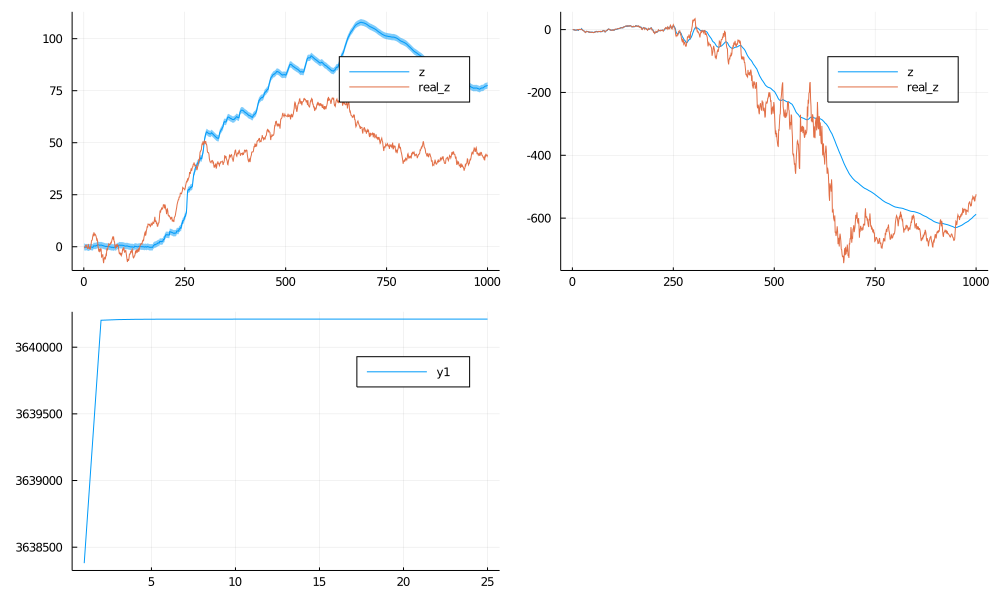

In [170]:
plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(z, label = :real_z)

plot(mean.(mx), ribbon = std.(mx), label = :z)
p2 = plot!(x, label = :real_z)

fevalues = reshape(fe, (iters, n))
p3 = plot(sum(fevalues, dims = 2))

plot(p1, p2, p3, size = (1000, 600))